#                                        Projet Vision par ordinateur:
                                     reconnaissance d'images par contenu, homographies

### Imports indispensables

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv


### Petites fonctions utiles d'affichage

In [2]:
def plot_img(img):
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

### Fonction d'analyse et de sauvegarde des descripteurs de fichiers d'une base de données

In [3]:
def creer_sauvegarder_descripteurs_bdd(dossier_bdd):
    # créer un detecteur de caractéristiques, notre choix se porte sur SIFT
    sift = cv.SIFT_create()
    
    # créer une liste des oeuvres présentes dans la base de données fournie
    oeuvres = []
    
    # utiliser le fonction ( très pratique ) os.walk() de python, qui permet de récupérer la liste de fichiers dans chaque dossier
    for (racine, dossiers, fichiers) in os.walk(dossier_bdd):
        # peupler notre liste d'oeuvres avec tous les fichiers disponibles dans la base de données
        oeuvres.extend(fichiers)
        
    # procéder au calcul des descripteurs de chaque oeuvre, et les sauvegarder dans le
    # même dossier sous la même nomenclature mais avec l'extension .npy
    for oeuvre in oeuvres:
        # si le fichier n'est pas déjà  un tableau de descripteurs
        if oeuvre.endswith('npy') == False:
            # convertir l'image aux nuances de gris ( grayscale)
            oeuvre_gray = cv.imread(os.path.join(dossier_bdd, oeuvre), cv.IMREAD_GRAYSCALE)
            # detecter et calculer les points clefs et leurs descripteurs respectifs, avec l'objet sift créé précédemment
            kp, desc = sift.detectAndCompute(oeuvre_gray, None)
            # enregistrer les descripteurs de caractéristiques de chaque image en format .npy, format de tableau numérique chez numpy
            # nous assumons ici l'hypothèse que notre bdd contient des images aux formats les plus communs (jpeg, png, jpg, jfif)
            if oeuvre.endswith('jpeg'):
                np.save(os.path.join(dossier_bdd, oeuvre.replace('jpeg', 'npy')), desc)
            if oeuvre.endswith('jpg'):
                np.save(os.path.join(dossier_bdd, oeuvre.replace('jpg', 'npy')), desc)
            if oeuvre.endswith('png'):
                np.save(os.path.join(dossier_bdd, oeuvre.replace('png', 'npy')), desc)
            if oeuvre.endswith('jfif'):
                np.save(os.path.join(dossier_bdd, oeuvre.replace('jfif', 'npy')), desc)
            print('Descripteurs %s extraits et sauvegardés' % oeuvre)
        


### Fonction de recherche de similitudes entre descripteurs

In [5]:
def quelle_oeuvre(chemin_contenu_a_identifier,
                  chemin_bdd,
                  nombre_correspondances_satisfaisant=15,
                  n_arbres=10,
                  n_verifications=100):

    # déclarer des variables conteneurs pour les données sur lesquelles on va travailler (descripteurs déjà extraits et sauvegardés dans la bdd)
    contenu_bdd = []
    descripteurs_bdd = []

    # rechercher tous les descripteurs dans notre base de données et les injecter dans la liste descripteurs_bdd
    for (racine, dossiers, fichiers) in os.walk(chemin_bdd):
        contenu_bdd.extend(fichiers)
    for fichier in contenu_bdd:
        if fichier.endswith('npy'):
            descripteurs_bdd.append(fichier)
    print('%s fichiers de descripteurs prêts à être exploités' % len(descripteurs_bdd))

    # Utiliser SIFT pour obtenir les caractéristiques interréssantes et leurs descriptifs de la photo dont on cherche à identifier le contenu partiel ou total
    sift = cv.SIFT_create()
    contenu_a_identifier = cv.imread(chemin_contenu_a_identifier, cv.IMREAD_GRAYSCALE)
    kp_contenu_a_identifier, dsc_contenu_a_identifier = sift.detectAndCompute(contenu_a_identifier, None)



    # Préparer un Matcher Flann qui utilisera un algorithm K_nearest_neighbors dans son approximation

    # commencer par définir les paramètres flann (paramètres recommandés dans la doc opencv pour caractéristiques extraites par SIFT)
    FLANN_INDEX_KDTREE = 1

    # Le premier paramètre de FlannBasedMatcher() est un dictionnaire spécifiant l'algorithme à exploiter et le nombre de trees de k_nearest_neighbors,
    # dans les tests, la valeur 10 a été utilisée, la doc recommande 10 pour des caractéristiques extraites par SIFT.
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=n_arbres)

    # Le deuxième paramètre de FlannBasedMatcher() est un autre dictionnaire spécifiant cette fois  le nombre de fois ou les arbres de l'index devraient être recursivement traversées,
    # pour les tests la valeur 100 a été utilisée car les données initiales sont minimes et les ressources suffisantes, néanmoins la doc recommande un bon compromis de 50.
    search_params = dict(checks=n_verifications)

    # créer le Flann Matcher avec les paramètres construits plus haut
    flann = cv.FlannBasedMatcher(index_params, search_params)



    # trouver les points de correspondances ( matchs ) , en utilisant "flann" crée précedemment pour comparer  les caractéristiques
    # du contenu à identifier, avec les caractéristiques de chaque image de la base de données utilisée.

    # déclarer une variable pour sauvegarder au fil des itérations, le nombre maximal de correspondances trouvés entre le contenu
    # à identifier et la photo la plus proche de la base de données
    haute_similitude = 0

    # déclarer également une variable pour le resultat de l'itération, ici le nom du fichier ayant eu la plus haute correspondance avec le contenu à identifier
    resultat = None
    
    progression = 0
    print('Analyse en cours, cette opération peut prendre quelques secondes, merci de patienter !\n')
    for fichier_descripteurs in descripteurs_bdd:
        
              
        # récupérer les données du fichier de descripteurs en cours
        descripteurs_iteration = np.load(os.path.join(chemin_bdd, fichier_descripteurs))
        
        # effectuer le matching et récupérer les correspondances dans la variable matches
        matches = flann.knnMatch(dsc_contenu_a_identifier, descripteurs_iteration, k=2)

        # sur ces "matches", on applique la méthode David Lowe, ratio test, pour ne garder que les matches pertinents
        matches_pertinents = []
        for p, q in matches:
            if p.distance < 0.7 * q.distance:
                matches_pertinents.append(p)

        nombre_matches_pertinents = len(matches_pertinents)
        candidat = fichier_descripteurs.replace('.npy', '')
        if nombre_matches_pertinents >= nombre_correspondances_satisfaisant:
            print('%s est un candidat crédible avec %d matches. \n' % (candidat, nombre_matches_pertinents))
            if nombre_matches_pertinents > haute_similitude:
                haute_similitude = nombre_matches_pertinents
                resultat = candidat
        progression = progression + 1
    
    oeuvre = None
    # Si pas de correspondance utile, informer l'utilisateur
    if resultat == None:
        print('Aucune homographie signifiante n a été identifiée')
        print('vous pouvez essayer une autre base de données ou affiner les paramètres initiaux. \n')

    # Si une correspondance signifiante est identifiée, informer l'utilisateur
    else:
        print('la correspondance la plus forte désigne: %s.' % resultat)
        print('Cette Oeuvre totalise %d matches. \n' % haute_similitude )
        

        # retrouver le fichier source du résultat, rappelons nous que précédemment nous travaillions sur des fichiers .npy
        contenu_bdd = []
        
        for (racine, dossiers, fichiers) in os.walk(chemin_bdd):
            contenu_bdd.extend(fichiers)
        for fichier in contenu_bdd:
            if fichier.startswith(resultat) and not fichier.endswith('npy'):
                oeuvre = fichier

    return oeuvre

### Fonction d'afichage des similitudes trouvées

In [6]:
def afficher_similitudes(fichier_photo_inconnu, fichier_photo_ressemblant):
    print('AFFICHAGE DES CORRESPONDANCES : ')
    img1 = cv.imread(fichier_photo_inconnu,cv.IMREAD_COLOR)          
    img2 = cv.imread(fichier_photo_ressemblant,cv.IMREAD_COLOR)
    
    # Initier un detecteur SIFT
    sift = cv.SIFT_create()
    # Trouver les bons points caractéristiques et leurs descripteurs
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    
    # Préparer un Flann matcher
    # construire les dictionnaires paramètres
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   
    
    flann = cv.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    
    # utiliser un masque pour ne dessiner que les points pertinents de similitudes
    matchesMask = [[0,0] for i in range(len(matches))]
    
    # filtrage grâce à la méthode de David Lowe, passage du ratio test
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.7*n.distance:
            matchesMask[i]=[1,0]
            
    # definir les paramètres de dessin
    draw_params = dict(matchColor = (0,255,0),
                       singlePointColor = (255,0,0),
                       matchesMask = matchesMask,
                       flags = cv.DrawMatchesFlags_DEFAULT)
    
    img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
    
    # afficher le parallélisme des deux images avec les correspondances tracées.
    plot_img(img3)


### Playground et Tests

#### Définition de la base de données à utiliser

In [7]:
# Vous pouvez ici modifier le chemin de la base de données à utiliser ( Placer votre bdd dans le dossier Jeux_De_Donnees)
chemin_bdd = './Jeux_De_Donnees/Collection_Peintures_MBL'

#### Extraction et sauvegarde des descripteurs de tous les fichiers de la base de données

In [8]:
creer_sauvegarder_descripteurs_bdd(chemin_bdd)

Descripteurs Achille_Parmi_Les_Filles_De_Lycomede__Adrien_Dassier__XVII.jpeg extraits et sauvegardés
Descripteurs Adele_Broelmann_Hippolyte_Flandrin__XIX.jpeg extraits et sauvegardés
Descripteurs Alexis_Champagne__Auguste_Flandrin__XIX.jpeg extraits et sauvegardés
Descripteurs Allegorie_De_La_Terre__Noel_Coypel__XVII.jpeg extraits et sauvegardés
Descripteurs Allegorie_justice_Romaine_Nicolas_Guy_Brenet_XVIII.jpeg extraits et sauvegardés
Descripteurs Andre_Camille_Perrichon__Charles_Grandon__XVIII.jpeg extraits et sauvegardés
Descripteurs Antoinette_Oudine__Hippoplyte_Flandrin__XIX.jpeg extraits et sauvegardés
Descripteurs Antoine_michel_Perrache_Marie_Anne_Perrache_XVIII.jpeg extraits et sauvegardés
Descripteurs Apotheose_Romaine__Thomas_Blanchet__XVII.jpeg extraits et sauvegardés
Descripteurs Arc_De_Triomphe_En_Ruines_Les_Joueurs_De_Cartes__Hubert_Robert_XVIII.jpeg extraits et sauvegardés
Descripteurs Attaque_De_Brigands__Sebastien_Bourdon__XVII.jpeg extraits et sauvegardés
Descripteu

Descripteurs Jeune_Femme_A_Sa_Toilette_Vanite__Nicolas_Regnier__XVII.jpeg extraits et sauvegardés
Descripteurs Jonas_Et_La_Baleine__Joseph_Vernet__XVIII.jpeg extraits et sauvegardés
Descripteurs Jugement_De_Paris_ Anonyme_ XVIII.jpeg extraits et sauvegardés
Descripteurs Jugement_De_Paris__Michel_Ange_Corneille__XVII.jpeg extraits et sauvegardés
Descripteurs La_Cene__Louis_Cretey__XVII.jpeg extraits et sauvegardés
Descripteurs La_Cene__Philippe_De_Champaigne__XVII.jpeg extraits et sauvegardés
Descripteurs La_Cene__Simon_Vouet__XVII.jpeg extraits et sauvegardés
Descripteurs La_Charite_De_Saint_Anne__Nicolas_Chaperon__XVII.jpeg extraits et sauvegardés
Descripteurs La_Charite_Romaine__Anonyme__XVIII.jpeg extraits et sauvegardés
Descripteurs La_Charite__Victor_Orsel__XIX.jpeg extraits et sauvegardés
Descripteurs La_Chasse_De_Diane__Domenico_Zampieri__XVIII.jpeg extraits et sauvegardés
Descripteurs La_Classe_De_Peinture_A_L_Ecole_Des_Beaux_Arts_De_Lyon__Jean_Marie_Jacomin__XIX.jpeg extraits 

Descripteurs L_Incredulite_De_Saint_Thomas__Simon_Vouet__XVII.jpeg extraits et sauvegardés
Descripteurs L_Invention_Des_Reliques_De_Saint_Gervais_Et_Saint_Protais__Philippe_De_Champaigne__XVII.jpeg extraits et sauvegardés
Descripteurs Madame_Jean_JAcques_De_Boissieu__Jean_Jacques_De_Boissieu__XVIII.jpeg extraits et sauvegardés
Descripteurs Marche_d_animaux_XVIII.jpeg extraits et sauvegardés
Descripteurs Marie_De_Medicis__Anonyme__XVII.jpeg extraits et sauvegardés
Descripteurs Marie_Madeleine_Jordan_En_Diane__Donatien_Nonotte__XVIII.jpeg extraits et sauvegardés
Descripteurs Marie_Soeur_De_Moise__Hippolyte_Flandrin__XIX.jpeg extraits et sauvegardés
Descripteurs Marine_Joseph_Vernet_XVIII.jpeg extraits et sauvegardés
Descripteurs Marine_Tempete__Anonyme__XVIII.jpeg extraits et sauvegardés
Descripteurs Marine__Adrien_Manglard__XVIII.jpeg extraits et sauvegardés
Descripteurs Martyre_De_Sainte_Catherine_D_Alexandrie__Claude_Guinet__XVI.jpeg extraits et sauvegardés
Descripteurs Mathilde_Mirab

Descripteurs Un_Jeune_Joueur_De_Flute_Au_Bord_De_La_Mer__Jean_Baptiste_Poncet__XIX.jpeg extraits et sauvegardés
Descripteurs Un_Port_De_Mer__Adriaen_Van_Der_Cabel__XVII.jpeg extraits et sauvegardés
Descripteurs Un_Soldat_Soigne_Par_Une_Religieuse__Claudius_Jacquand__XIX.jpeg extraits et sauvegardés
Descripteurs Vanite__Simon_Renard_De_Saint_Andre__XVII.jpeg extraits et sauvegardés
Descripteurs Vase_De_Fleurs_Et_Perroquet__Jean_Baptiste_Monnoyer__XVII.jpeg extraits et sauvegardés
Descripteurs Venus_Et_Adonis__Laurent_Pecheux__XVIII.jpeg extraits et sauvegardés
Descripteurs Vue_De_Pierre_Scize__Alexandre_Hyacinthe_Dunouy__XIX.jpeg extraits et sauvegardés
Descripteurs Vue_De_Tivoli__Jean_Joseph_Xavier_Bidauld__XIX.jpeg extraits et sauvegardés
Descripteurs Vue_Prise_De_Valmontone__Victor_Bertin__XIX.jpeg extraits et sauvegardés


#### Tests: essais successifs sur différentes imagettes, un test par cellule 

##### Test 1 : imagette fond noir uniforme ( aucune caractéristique )

In [13]:
chemin_contenu_a_identifier1 = './Jeux_De_Donnees/Contenus_A_Identifier/noir_uniforme.jpg'

resultat = quelle_oeuvre(chemin_contenu_a_identifier1, chemin_bdd )



287 fichiers de descripteurs prêts à être exploités
Analyse en cours, cette opération peut prendre quelques secondes, merci de patienter !

Aucune homographie signifiante n a été identifiée
vous pouvez essayer une autre base de données ou affiner les paramètres initiaux. 



##### Test 2 : imagette sans modification de taille, d'orientation ou de perspective

287 fichiers de descripteurs prêts à être exploités
Analyse en cours, cette opération peut prendre quelques secondes, merci de patienter !

Francois_premier_XVIII est un candidat crédible avec 32 matches. 

la correspondance la plus forte désigne: Francois_premier_XVIII.
Cette Oeuvre totalise 32 matches. 

AFFICHAGE DES CORRESPONDANCES : 


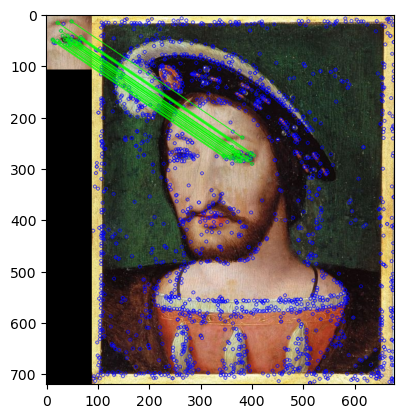

In [10]:
chemin_contenu_a_identifier2 = './Jeux_De_Donnees/Contenus_A_Identifier/oeil_gauche_Francois_premier.jpeg'

resultat = quelle_oeuvre(chemin_contenu_a_identifier2, chemin_bdd)

afficher_similitudes(chemin_contenu_a_identifier2, os.path.join(chemin_bdd, resultat))

##### Test 3 et 4 : Comparatif resultat pour un même extrait, imagette nette et imagette avec bruit ( stries blanches verticales)

287 fichiers de descripteurs prêts à être exploités
Analyse en cours, cette opération peut prendre quelques secondes, merci de patienter !

La_Cene__Philippe_De_Champaigne__XVII est un candidat crédible avec 76 matches. 

la correspondance la plus forte désigne: La_Cene__Philippe_De_Champaigne__XVII.
Cette Oeuvre totalise 76 matches. 

AFFICHAGE DES CORRESPONDANCES : 


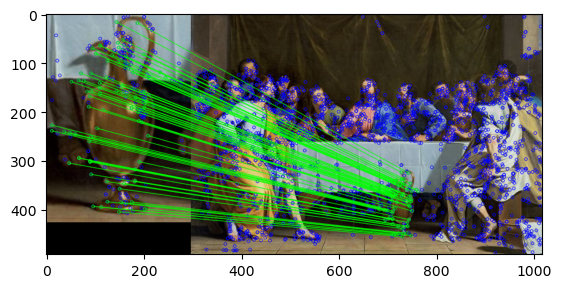

In [11]:
chemin_contenu_a_identifier3 = './Jeux_De_Donnees/Contenus_A_Identifier/recipient_sans_bruit.png'

resultat = quelle_oeuvre(chemin_contenu_a_identifier3, chemin_bdd)

afficher_similitudes(chemin_contenu_a_identifier3, os.path.join(chemin_bdd, resultat))


287 fichiers de descripteurs prêts à être exploités
Analyse en cours, cette opération peut prendre quelques secondes, merci de patienter !

Adele_Broelmann_Hippolyte_Flandrin__XIX est un candidat crédible avec 68 matches. 

Alexis_Champagne__Auguste_Flandrin__XIX est un candidat crédible avec 63 matches. 

Antoinette_Oudine__Hippoplyte_Flandrin__XIX est un candidat crédible avec 41 matches. 

Antoine_michel_Perrache_Marie_Anne_Perrache_XVIII est un candidat crédible avec 16 matches. 

Attaque_D_Une_Ville_De_Nuit__Charles_Parrocel__XVIII est un candidat crédible avec 66 matches. 

Attributs_Chapetres__Jean_Baptiste_Huet__XVIII est un candidat crédible avec 18 matches. 

Autoportrait_Au_Chevalet__Hippolyte_Flandrin__XIX est un candidat crédible avec 40 matches. 

Autoportrait_A_La_Casquette_Hippolyte_Flandrin__XIX est un candidat crédible avec 29 matches. 

Autoportrait_A_La_Palette__Louis_Lamothe__XIX est un candidat crédible avec 31 matches. 

Autoportrait_En_Saint_Augustin__Jean_Bapti

Le_Bien_Et_Le_Mal__Victor_Orsel est un candidat crédible avec 20 matches. 

Le_Chatiment_des_Vices_Thomas_Blanchet_XVII est un candidat crédible avec 19 matches. 

Le_Compte_Sebastien_Des_Guidi__Auguste_Flandrin__XIX est un candidat crédible avec 56 matches. 

Le_Dante_Conduit_Par_Virgile_Offre_Des_Consolations_Aux_Ames_Des_Envieux__Hippolyte_Flandrin__XIX est un candidat crédible avec 15 matches. 

Le_Duo__Nicolas_LAncret__XVIII est un candidat crédible avec 22 matches. 

Le_Jugement_De_Salomon__Jean_Francois_De_Troy__XVIII est un candidat crédible avec 37 matches. 

Le_Lavement_Des_Pieds__Anonyme__XVI est un candidat crédible avec 18 matches. 

Le_Levite_D_Ephraim__Alexandre_Caminade__XIX est un candidat crédible avec 22 matches. 

Le_Marechal_Francois_De_Neuville_De_Villeroy__Anonyme__XVII est un candidat crédible avec 62 matches. 

Le_Mariage_Mystique_De_Saint_Catherine__Hyacinthe_Colin_De_Vermont__XVIII est un candidat crédible avec 51 matches. 

Le_Rocher__Jean_Honore__Fragonard_

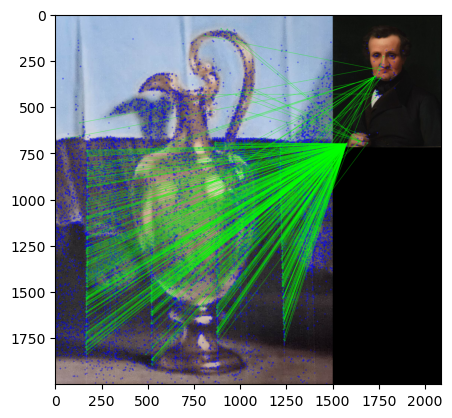

In [11]:

chemin_contenu_a_identifier4 = './Jeux_De_Donnees/Contenus_A_Identifier/recipient_avec_bruit.jpg'

resultat = quelle_oeuvre(chemin_contenu_a_identifier4, chemin_bdd)

afficher_similitudes(chemin_contenu_a_identifier4, os.path.join(chemin_bdd, resultat))


##### Test 5 : imagette avec changement de taille et d'orientation

287 fichiers de descripteurs prêts à être exploités
Analyse en cours, cette opération peut prendre quelques secondes, merci de patienter !

Femme_A_Sa_Fenetre__Jean_Raoux__XVIII est un candidat crédible avec 35 matches. 

la correspondance la plus forte désigne: Femme_A_Sa_Fenetre__Jean_Raoux__XVIII.
Cette Oeuvre totalise 35 matches. 

AFFICHAGE DES CORRESPONDANCES : 


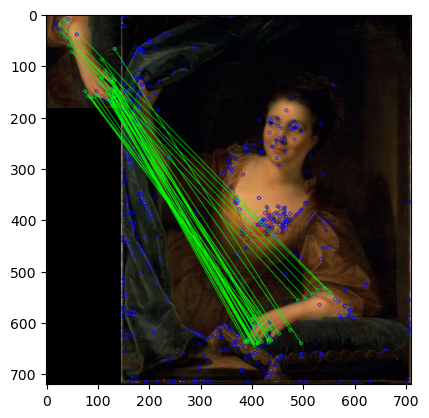

In [12]:
chemin_contenu_a_identifier5 = './Jeux_De_Donnees/Contenus_A_Identifier/main_dodue_noble_XVIII.jpeg'

resultat = quelle_oeuvre(chemin_contenu_a_identifier5, chemin_bdd)

afficher_similitudes(chemin_contenu_a_identifier5, os.path.join(chemin_bdd, resultat))

##### Test 6 : imagette avec changement de taille et de perspective

287 fichiers de descripteurs prêts à être exploités
Analyse en cours, cette opération peut prendre quelques secondes, merci de patienter !

Pamela_Brame__Hippolyte_Flandrin__XIX est un candidat crédible avec 4 matches. 

Un_Enfant_Conduisant_Un_Aveugle__Anonyme__XVIII est un candidat crédible avec 4 matches. 

la correspondance la plus forte désigne: Pamela_Brame__Hippolyte_Flandrin__XIX.
Cette Oeuvre totalise 4 matches. 

AFFICHAGE DES CORRESPONDANCES : 


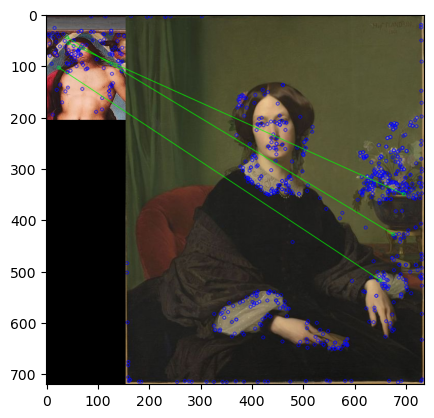

In [13]:
chemin_contenu_a_identifier6 = './Jeux_De_Donnees/Contenus_A_Identifier/ascencion_christ_vue_plongeante.jpg'

resultat = quelle_oeuvre(chemin_contenu_a_identifier6, chemin_bdd, nombre_correspondances_satisfaisant = 4)

afficher_similitudes(chemin_contenu_a_identifier6, os.path.join(chemin_bdd, resultat))


##### Tests libres : spécifier chemin imagette

In [12]:

chemin_contenu_a_identifier_libre = 

resultat = quelle_oeuvre(chemin_contenu_a_identifier_libre, chemin_bdd)

afficher_similitudes(chemin_contenu_a_identifier_libre, os.path.join(chemin_bdd, resultat))

SyntaxError: invalid syntax (128178795.py, line 1)